In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import json
#from nav_msgs.msg import OccupancyGrid

In [2]:
class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.type = 0    #types: free, oc (= occupied), path, start, end
        self.start_dis = float('inf')    #distance to start node
        self.end_dis = float('inf')    #distance to end node

In [3]:
#create grid
grid = []    #empty gird (list)
rows = 100    #number of rows
columns = 100   #number of columns

for i in range(rows):    #create grid where all nodes are free
    row_nodes = []    #empty row
    for j in range(columns):    #fill row
        node = Node(j, i)    #create node
        row_nodes.append(node)    #add node to row
    grid.append(row_nodes)    #add row to grid

In [4]:
#create obstacles
x_pos = np.array([49])
y_pos = np.array([49])

for i in range(len(y_pos)):
    for j in range(len(x_pos)):
        x = x_pos[i]
        y = y_pos[i]
        #print(x,y)
        grid[y][x].type = 100    #occupied

#set start node
start_coor = np.array([0, 49])    #[x, y]
grid[start_coor[1]][start_coor[0]].type = 0    #set start
start = grid[start_coor[1]][start_coor[0]]

#set end node
end_coor = np.array([99, 49])    #[x, y]
grid[end_coor[1]][end_coor[0]].type = 0    #set end
end = grid[end_coor[1]][end_coor[0]]

In [5]:
def dis_curr_end(curr, end):    #minimal distance from current node to end node
    
    x_dis = abs(end.x - curr.x)
    y_dis = abs(end.y - curr.y)
    
    diag = min(x_dis, y_dis)    #minimal diagonal steps needed to reach end
    strai = x_dis + y_dis - 2 * diag    #minimal straight steps needed to reach end
    
    dis = math.sqrt(2) * diag + strai
    
    return dis

In [6]:
def min_end_dis(next_nodes):
    
    next_node = None
    
    for i in range(len(next_nodes)):
        
        node = next_nodes[i]
        
        if next_node == None or node.end_dis < next_node.end_dis:    #set next_node to the node with the smallest distance to end
            next_node = node

    return next_node

In [7]:
def get_nei(grid, curr):
    
    rows = len(grid)    #determine number of rows
    columns = len(grid[0])    #determine number of columns
    
    direc = np.array([[1, 0], [0, 1], [0, -1], [-1, 0]])#, [-1, 1], [1, 1], [1, -1], [-1, -1]])    #possible directions (vertical, horizontal and #diagonal)
    
    nei_nodes = []    #list where neighbor nodes are added
    
    for j in range(4):
        
        direc_j = direc[j,:]
        
        nei_x = curr.x + direc_j[0]
        nei_y = curr.y + direc_j[1]

        if nei_x >= 0 and nei_y >= 0 and nei_x < columns and nei_y < rows:    #adds neighbor for every direction if in domain
            nei_nodes.append(grid[nei_y][nei_x])

    return nei_nodes

In [8]:
def dis_curr_nei(curr, nei_node):
    dis = math.sqrt(((curr.x - nei_node.x)**2) + ((curr.y - nei_node.y)**2))    #distance between two nodes
    return dis

In [9]:
def find_path(grid, came_from, curr):    #reconstructs the optimal path from came_from
    path = []
    key = str(curr.x) + ' ' + str(curr.y)
    while key in came_from:
        
        path.insert(0, curr)
        curr = came_from[key]
        key = str(curr.x) + ' ' + str(curr.y)
        #curr.type = 'path'
        
    return path

In [10]:
def process_occupancy_grid(occupancy_grid_msg: OccupancyGrid):
    resolution = occupancy_grid_msg.info.resolution
    width = occupancy_grid_msg.info.width
    height = occupancy_grid_msg.info.height
    origin = occupancy_grid_msg.info.origin

    data = occupancy_grid_msg.data

    oc_grid = [data[i:i + width] for i in range(0, len(data), width)]

    grid = []    #empty gird (list)
    rows = height    #number of rows
    columns = width   #number of columns

    for i in range(rows):    #create grid where all nodes are free
        row_nodes = []    #empty row
        for j in range(columns):    #fill row
            node = Node(j, i)    #create node
            node.type = data[j, i]
            row_nodes.append(node)    #add node to row
        grid.append(row_nodes)    #add row to grid
    
    #set start node 1
    start_coor = np.array([1, 1])    #[x, y]
    start = grid[start_coor1[1]][start_coor1[0]]
    
    #set end node 1
    end_coor = np.array([98, 98])    #[x, y]
    end = grid[end_coor1[1]][end_coor1[0]]

    return grid, start, end

NameError: name 'OccupancyGrid' is not defined

In [21]:
def add_buffer(grid, buffer, start, end):
    
    rows = len(grid)
    columns = len(grid[0])

    for i in range(rows):
        for j in range(columns):
            if grid[j][i].type > 51:    #if it's an obstacle
                for di in range(-buffer, buffer + 1):
                    for dj in range(-buffer, buffer + 1):
                        ni, nj = i + di, j + dj
                        if 0 <= ni < rows and 0 <= nj < columns:    #check if the neighbor is in bounds and within the buffer distance
                            if grid[ni][nj] != start and grid[nj][ni] != end and grid[nj][ni].type != 100:    #avoid overwriting start, end, or 100
                                    grid[ni][nj].type = 51    #set psudo obstacle
                                    
    return

In [23]:
def a_star(grid, start, end):
    
    next_nodes = []    #list where nodes are added which are to be examined next
    examined_nodes = []    #list where nodes are added that which were examined
    came_from = {}    #dictionary where keys are node coordinates and values is previous node

    start.start_dis = 0    #distance to start node
    start.end_dis = dis_curr_end(start, end)    #distance to end node

    next_nodes.append(start)    #first node to examine

    buffer = 3    #size of buffer zone
    add_buffer(grid, buffer, start, end)    #add buffer zone

    while len(next_nodes) > 0:    #loop until all nodes are examined

        curr = min_end_dis(next_nodes)    #set the current node to the node of next_nodes that is closest to end
        next_nodes.remove(curr)
        examined_nodes.append(curr)

        if curr.x == end.x and curr.y == end.y:    #ends loop if end is found
            path = find_path(grid, came_from, curr)
            return path

        nei_nodes = get_nei(grid, curr)    #get neighbor nodes of current node
        
        for i in range(len(nei_nodes)):
            
            nei_node = nei_nodes[i]    #neighbor node i

            if nei_node in examined_nodes or nei_node.type > 50:    #do not examine node that are already examined or occupied
                continue

            adj_node_1 = grid[curr.y][nei_node.x]
            adj_node_2 = grid[nei_node.y][curr.x]
            if adj_node_1.type > 50 and adj_node_2.type > 50:    #do not examine diagonal neighbor node if both adjacent neighbor nodes are occupied
                continue

            start_dis_nei = curr.start_dis + dis_curr_nei(curr, nei_node)    #distance from neighbor node to start
            if nei_node not in next_nodes:    #add nei_node to next_nodes
                next_nodes.append(nei_node)
            elif start_dis_nei > nei_node.start_dis:    #do not examine node that moves us back to start
                continue

            came_from[str(nei_node.x) + ' ' + str(nei_node.y)] = curr    #puts current node into came_from with key of neighbor node
            nei_node.start_dis = start_dis_nei    #sets start_dis of neighbor node
            nei_node.end_dis = nei_node.start_dis + dis_curr_end(nei_node, end)    #sets end_dis of neighbor node

In [24]:
#testing
path = a_star(grid, start, end)

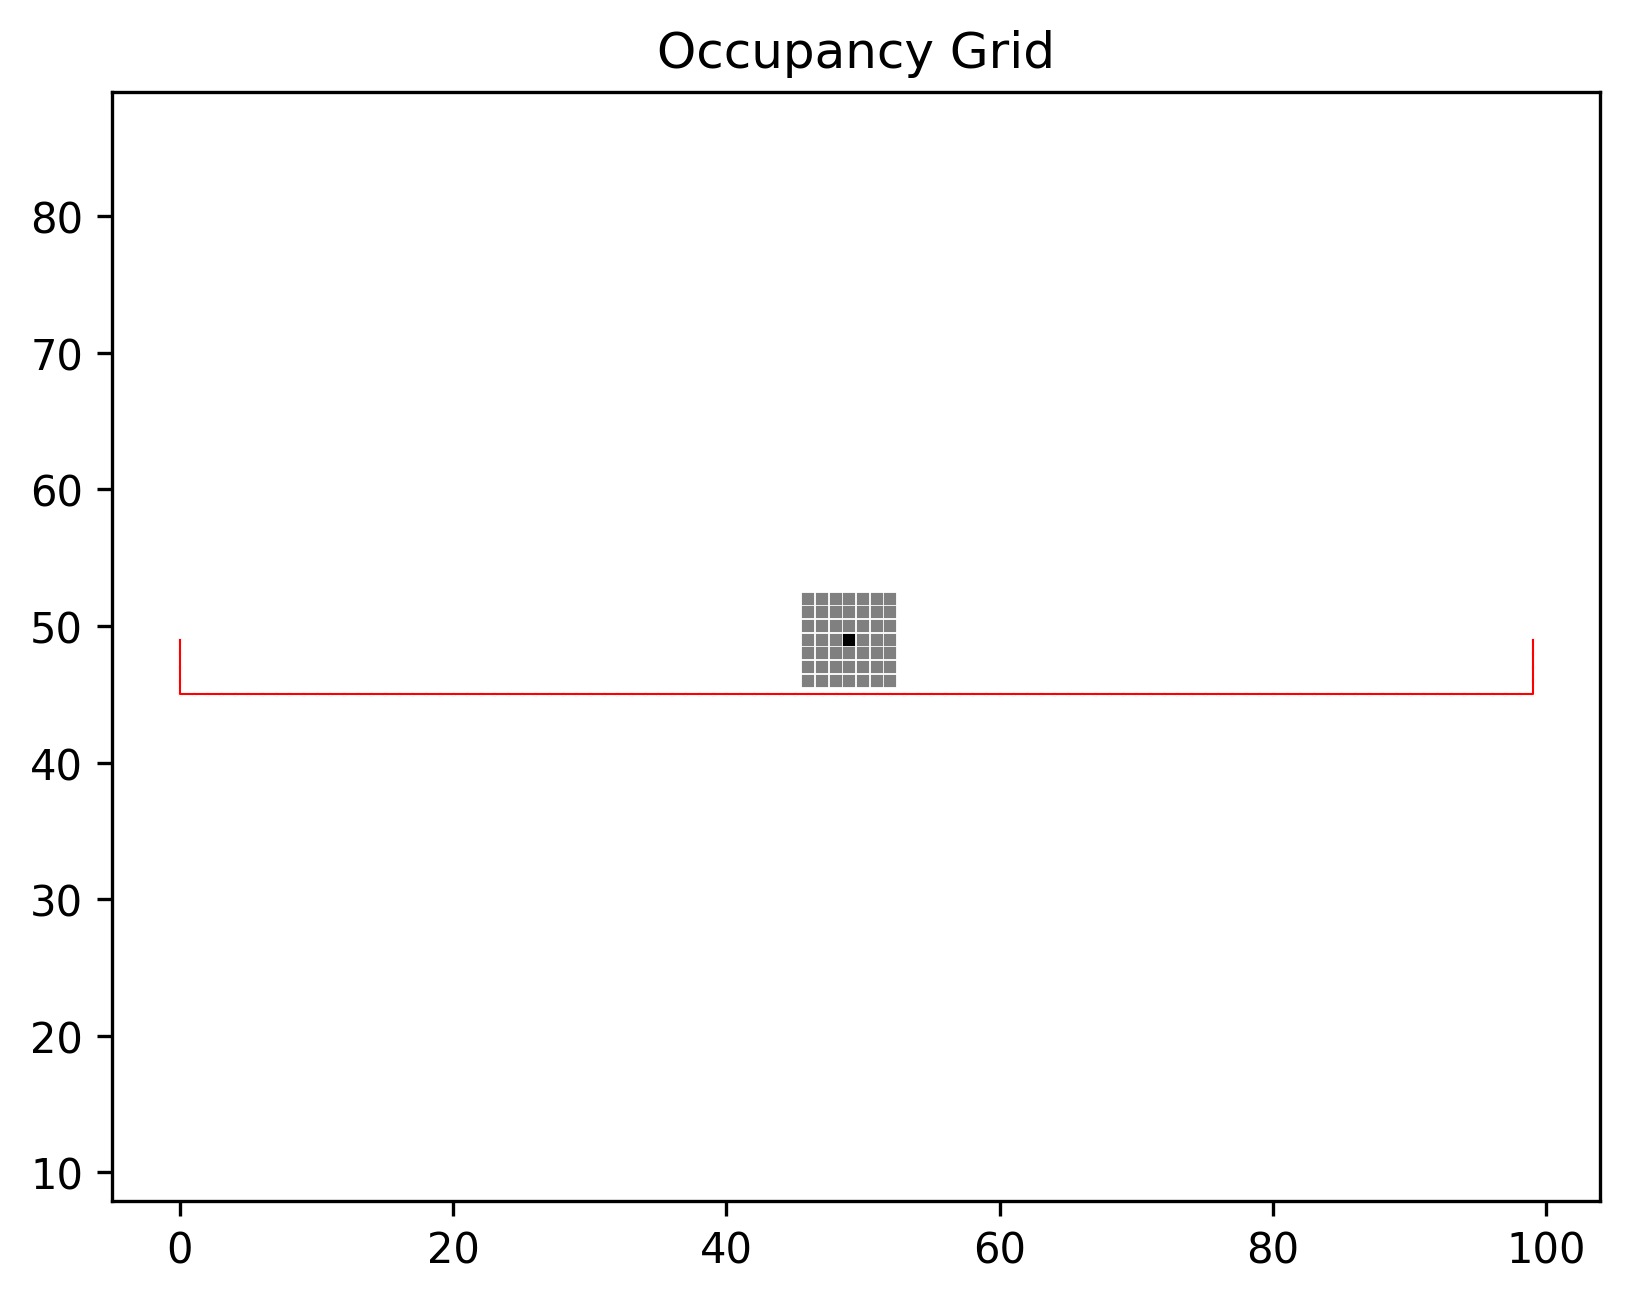

In [25]:
#display grid
plt.figure(dpi=300)
plt.title('Occupancy Grid')

oc1_x, oc1_y, path1_x, path1_y, poc1_x, poc1_y = [[] for _ in range(6)]

rows = len(grid)    #determine number of rows
columns = len(grid[0])

for i in range(len(path)+1):
    if i == 0:
        path1_x.append(start.x)
        path1_y.append(start.y)
    else:
        path1_x.append(path[i-1].x)
        path1_y.append(path[i-1].y)

for i in range(rows):
    for j in range(columns):
        if grid[j][i].type > 51:
            oc1_x.append(grid[j][i].x)
            oc1_y.append(grid[j][i].y)
        elif grid[j][i].type == 51:
            poc1_x.append(grid[j][i].x)
            poc1_y.append(grid[j][i].y)
            
plt.plot(path1_x, path1_y, color='red', linewidth=0.5, marker='o', markersize=0.01)
plt.plot(oc1_x, oc1_y, 's', color='black', markersize=1.7)
plt.plot(poc1_x, poc1_y, 's', color='grey', markersize=1.7)

plt.axis('equal')

plt.show()